# Modeling and Simulation in Python

Insulin minimal model

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Data

We have data from Pacini and Bergman (1986), "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test", *Computer Methods and Programs in Biomedicine*, 23: 113-122..

In [3]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

The return value from `interpolate` is a function.

### The insulin minimal model

In addition to the glucose minimal mode, Pacini and Bergman present an insulin minimal model, in which the concentration of insulin, $I$, is governed by this differential equation:

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

**Exercise:**  Write a version of `make_system` that takes the parameters of this model, `I0`, `k`, `gamma`, and `G_T` as parameters, along with a `DataFrame` containing the measurements, and returns a `System` object suitable for use with `run_simulation` or `run_odeint`.

Use it to make a `System` object with the following parameters:

In [7]:
params = Params(I0 = 360,
                k = 0.25,
                gamma = 0.004,
                G_T = 80)

,values
I0,360.000
k,0.250
gamma,0.004
G_T,80.000


In [11]:
# Solution goes here
data

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51
10,216,49
12,211,45
14,205,41
16,196,35


In [12]:
# Solution goes here
G = interpolate(data.glucose)
G(32)

array(142.)

In [14]:
# Solution goes here
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of I0, k, gamma, G_T
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    I0, k, gamma, G_T = params
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(I=I0)
    
    return System(I0=I0, k=k, gamma=gamma,
                  init=init, G_T=G_T,
                  t_0=t_0, t_end=t_end)

system = make_system(params, data)

,values
I0,360
k,0.25
gamma,0.004
init,I 360.0 dtype: float64
G_T,80
t_0,0
t_end,182


**Exercise:** Write a slope function that takes state, t, system as parameters and returns the derivative of `I` with respect to time.  Test your function with the initial condition $I(0)=360$.

### The insulin minimal model

In addition to the glucose minimal mode, Pacini and Bergman present an insulin minimal model, in which the concentration of insulin, $I$, is governed by this differential equation:

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

In [13]:
# Solution goes here
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivative of I
    """
    I = state
    unpack(system)
    
    dIdt = -k*I + gamma * (G(t) - G_T) * t
    
    return dIdt

In [15]:
# Solution goes here
slope_func(system.init, 0, system)

I   -90.0
dtype: float64

**Exercise:** Run `run_ode_solver` with your `System` object and slope function, and plot the results, along with the measured insulin levels.

In [16]:
# Solution goes here
%time results, details = run_ode_solver(system, slope_func, t_eval=data.index);

Wall time: 69.7 ms


In [19]:
results

,I
0,360.000000
2,219.587675
4,137.706929
6,89.512943
8,61.679284
10,45.769844
12,37.063244
14,32.992284
16,31.429035
19,31.815372


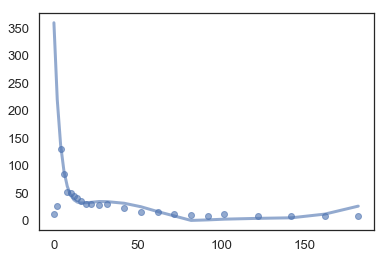

In [21]:
# Solution goes here
plot(results.I, 'b-')
plot(data.insulin, 'bo')

**Exercise:**  Write an error function that takes a sequence of parameters as an argument, along with the `DataFrame` containing the measurements.  It should make a `System` object with the given parameters, run it, and compute the difference between the results of the simulation and the measured values.  Test your error function by calling it with the parameters from the previous exercise.

Hint: As we did in a previous exercise, you might want to drop the errors for times prior to `t=8`.

In [26]:
# Solution goes here
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_ode_solver(system, slope_func, t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.I - data.insulin
    return errors.loc[8:]

In [27]:
# Solution goes here
error_func(params, data)

I0       360.000
k          0.250
gamma      0.004
G_T       80.000
dtype: float64


8      10.679284
10     -3.230156
12     -7.936756
14     -8.007716
16     -3.570965
19      1.815372
22      2.570822
27      7.101640
32      3.815164
42      8.932695
52      9.598985
62      0.776848
72     -3.215782
82    -10.348094
92     -7.387625
102    -9.052108
122    -3.578155
142    -3.580564
162     3.157260
182    18.705778
dtype: float64

**Exercise:** Use `fit_leastsq` to find the parameters that best fit the data.  Make a `System` object with those parameters, run it, and plot the results along with the measurements.

In [30]:
# Solution goes here
best_params, fit_details = fit_leastsq(error_func, params, data)
best_params

[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.60000005e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60000000e+02 2.50000004e-01 4.00000000e-03 8.00000000e+01]
[3.60000000e+02 2.50000000e-01 4.00000006e-03 8.00000000e+01]
[3.60000000e+02 2.50000000e-01 4.00000000e-03 8.00000012e+01]
[3.22636021e+02 2.49583193e-01 3.78628197e-03 8.06557246e+01]
[3.22636026e+02 2.49583193e-01 3.78628197e-03 8.06557246e+01]
[3.22636021e+02 2.49583197e-01 3.78628197e-03 8.06557246e+01]
[3.22636021e+02 2.49583193e-01 3.78628203e-03 8.06557246e+01]
[3.22636021e+02 2.49583193e-01 3.78628197e-03 8.06557258e+01]
[3.48684244e+02 2.49593826e-01 3.66414539e-03 8.12020713e+01]
[3.48684249e+02 2.49593826e-01 3.66414539e-03 8.12020713e+01]
[3.48684244e+02 2.49593830e-01 3.66414539e-03 8.12020713e+01]
[3.48684244e+02 2.49593826e-01 3.66414545e-03 8.12020713e+01]
[3.48684244e+02 2.49593826e-01 3.66414539e-03 8.12020725e+01]
[3.63028853e+02 2.49942481e-01

,values
I0,363.985013
k,0.249866
gamma,0.003484
G_T,79.608511


In [31]:
system = make_system(best_params, data)
results_best_p, details = run_ode_solver(system, slope_func, t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Saving figure to file figs/chap19-fig01.pdf


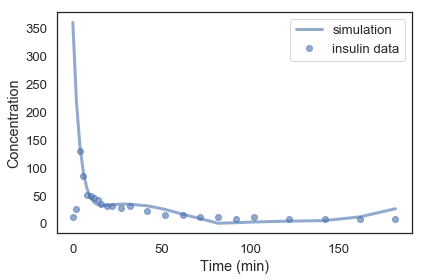

In [32]:
# Solution goes here
plot(results.I, label='simulation')
plot(data.insulin, 'bo', label='insulin data')

decorate(xlabel='Time (min)',
         ylabel='Concentration')

savefig('figs/chap19-fig01.pdf')

In [15]:
# Solution goes here

In [16]:
# Solution goes here

**Exercise:** Using the best parameters, estimate the sensitivity to glucose of the first and second phase pancreatic responsivity:

$ \phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)} $

$ \phi_2 = \gamma \times 10^4 $

For $G_0$, use the best estimate from the glucose model, 290.  For $G_b$ and $I_b$, use the inital measurements from the data.


In [38]:
# Solution goes here
I0, k, gamma, G_T = best_params
I0, k, gamma, G_T

(363.9850127403283,
 0.24986563753885782,
 0.0034838571855024727,
 79.6085114658404)

In [40]:
# Solution goes here
G0 = 290
Gb = data.glucose[0]
Ib = data.insulin[0]
Imax = data.insulin.max()
G0, Gb, Ib, Imax

(290, 92, 11, 130)

In [41]:
# Solution goes here
theta_1 = (Imax - Ib) / (k * (G0 - Gb))

2.40533314996799

In [42]:
# Solution goes here
theta_2 = gamma * 10**4

34.838571855024725

In [21]:
# Solution goes here